# CMB angular power spectrum

The goal of this notebook (work in progress) is to explain the Cosmic Microwave Background angular power spectrum and understand its statistical properties.


## Maps vs power spectra

If we are thinking about anisotropies of the CMB, the simplest picture is to think of a two-dimensional map with hot spots and cold spots, such as the one shown here. The color scale has units of microKelvin and it represents how much the CMB temperature at each point on the sky differs from the average temperature of 2.73 K. The figure uses a [Mollweide projection](https://en.wikipedia.org/wiki/Mollweide_projection) to depict the entire sky (surface of a 2-sphere) as a flat two-dimensional image.

In [2]:
# Set up notebook.
%matplotlib inline
import numpy as np
from matplotlib import rc
rc('text', usetex=True)
import matplotlib.pyplot as plt
import healpy as hp

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


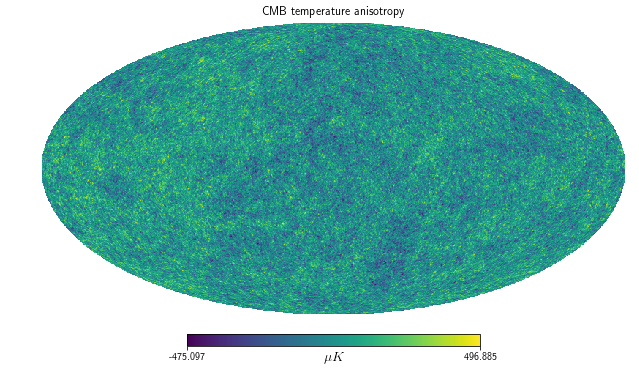

In [20]:
# Read angular power spectrum from file (generated with CAMB via LAMBDA web interface).
Dl = np.genfromtxt('camb_72686694_lensedcls.dat')
# Convert from D_ell to C_ell.
Cl = Dl[:,1] * 2.0 * np.pi / Dl[:,0] / (Dl[:,0] + 1.0)
# Create map and plot.
Tmap = hp.synfast(Cl[0:2048], 512, pol=False, new=True)
hp.mollview(Tmap, unit='$\mu K$', title='CMB temperature anisotropy')


This map has a lot of structure! You can see small hot and cold spots, as well as larger regions that tend to favor hotter or cooler temperatures. The total number of pixels in this map is 3,145,728. You might imagine that any attempt to compare these data with theory might require the theory to make a prediction for the temperature in every pixel.

However, an amazing feature of the CMB is that it can be described by a much smaller amount of information. This is because the individual hot and cold spots themselves are not physically meaningful. Instead we understand the Cosmic Microwave Background as a random realization of an **isotropic Gaussian random field** (we will soon dig into the precise mathematical definition of those terms).

All of the physically meaningful information in the above map is contained in its **angular power spectrum**, plotted below. That angular power spectrum contains just 2048 numbers -- way less than the number of pixels in the map. In the literature, this has been referred to as [Radical Compression of Cosmic Microwave Background Data](https://arxiv.org/abs/astro-ph/9808264).

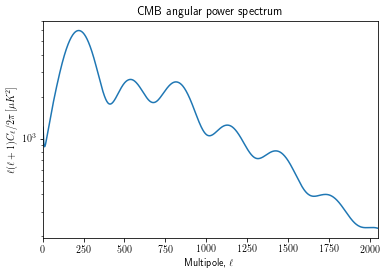

In [21]:
# Plot angular power spectrum.
plt.semilogy(Dl[0:2048,0], Dl[0:2048,1])
plt.xlim([0, 2048])
plt.title('CMB angular power spectrum')
plt.xlabel('Multipole, $\ell$')
plt.ylabel('$\ell (\ell + 1) C_\ell / 2 \pi \, [\mu K^2]$')


The x-axis of this figure represents angular scales, with large angular scales at small multipoles (left-hand side of figure) and small angular scales at large multipoles (right-hand side). The multipoles, $\ell$, refer to [spherical harmonics](https://en.wikipedia.org/wiki/Spherical_harmonics) and $\ell = 180$ roughly corresponds to an angular scale of a degree. For comparison, the diameter of the full moon is about half a degree, so hot spots in the CMB that are the size of the full moon would show up near $\ell = 400$.

The y-axis of this figure represents the **fluctuation power** at each angular scale. Note that this power spectrum is positive-definite. The map, on the other hand, includes equal amounts of positive and negative fluctuations. A useful way to think of the power spectrum is as the square of the fluctuations, so both negative and positive temperature fluctuations will contribute to positive power.

From the shape of the power spectrum, you can see that there are more temperature fluctuations (or larger amplitude temperature fluctuations) at certain angular scales. For instance, the first and largest peak shows up at $\ell \sim 200$. For an even more radical compression of the CMB data, we can describe this angular power spectrum using just six physical parameters -- this is $\Lambda$CDM cosmology. There are a few ways to choose these six parameters, but one option is:

* Density of baryonic matter
* Density of dark matter
* Geometry of the universe (is space-time flat?)
* Amplitude of scalar fluctuations (how much fluctuation power should we see in the CMB and elsewhere?)
* Scalar spectral index (does the amplitude of fluctuations depend on scale?)
* Optical depth to recombination (this has to do with how our view of the CMB is affected by intervening ionized matter)

This description of the CMB is necessary to connect the observations to theory, but we are going to focus on the step of converting a map into an angular power spectrum. The statistics of the map (isotropic, Gaussian) will determine the statistics of the power spectrum (non-Gaussian). We will also extend this operation to handle maps of polarization.

## Gaussian statistics

CMB maps generally obey Gaussian statistics (not completely true with lensing and foregrounds, but we'll ignore that for now). To better understand CMB data analysis, let's review some properties of Gaussian distributions.

The Gaussian (or normal) probability density function (pdf) is given by:
$$ P(x) = \frac{1}{\sqrt{2 \pi \sigma^2}} \exp \left( - \frac{(x - \mu)^2}{2 \sigma^2} \right) $$

We can plot this pdf for a few values of $\mu$ and $\sigma$:

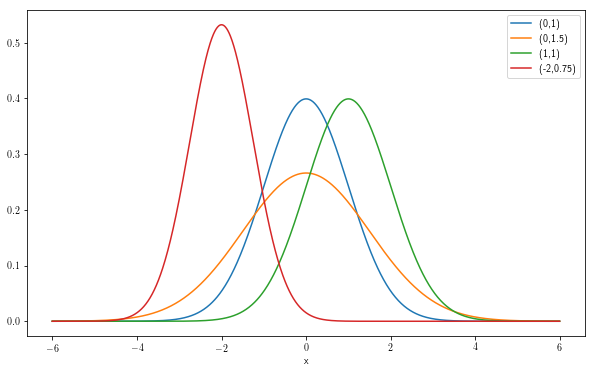

In [22]:
x = np.arange(-6, 6, 0.01)
mu_vals = [0, 0, +1, -2]
sigma_vals = [1, 1.5, 1, 0.75]
fig = plt.figure(figsize=(10,6))
for (mu, sigma) in zip(mu_vals, sigma_vals):
    pdf = np.exp(-(x - mu)**2 / (2.0 * sigma**2)) / np.sqrt(2.0 * np.pi * sigma**2)
    plt.plot(x, pdf, label="({},{})".format(mu, sigma))
plt.xlabel('x')
plt.legend()

As expected, the distributions peak at $x = \mu$. Distributions with small $\sigma$ are tall and narrow (red); distributions with large $\sigma$ are short and wide (orange).

Now, let's work through some math related to the Gaussian pdf.

### Normalization

$P(x)$ is a probability density function, so its integral should be equal to one. This is the same as saying that there is 100% probability that $x$ is *some value*. To check that $P(x)$ is properly normalized, we will need to use a clever trick.

$$ 
\begin{align}
N &= \int_{-\infty}^{\infty} P(x) dx \\
&= \frac{1}{\sqrt{2 \pi \sigma^2}} \int_{-\infty}^{\infty} \exp \left( - \frac{(x - \mu)^2}{2 \sigma^2} \right) dx
\end{align}
$$

To simplify the integral, let's make the substitution $y = (x - \mu) / (\sqrt{2} \sigma)$.

$$
\begin{align}
N &= \frac{\sqrt{2} \sigma}{\sqrt{2 \pi \sigma^2}} \int_{-\infty}^{\infty} \exp \left( - y^2 \right) dy \\
&= \frac{1}{\sqrt{\pi}} \int_{-\infty}^{\infty} \exp \left( - y^2 \right) dy 
\end{align}
$$

To solve this integral, we will square both sides of the equation and then convert from Cartesian $(x, y)$ coordinates to polar $(r, \theta)$ coordinates.

$$
\begin{align}
N^2 &= \frac{1}{\pi} \left( \int_{-\infty}^{\infty} \exp \left( - x^2 \right) dx \right) \left( \int_{-\infty}^{\infty} \exp \left( - y^2 \right) dy \right) \\
&= \frac{1}{\pi} \int_{-\infty}^{\infty} \int_{-\infty}^{\infty} \exp \left( - (x^2 + y^2) \right) dx dy \\
&= \frac{1}{\pi} \int_{0}^{\infty} \int_{-\pi}^{\pi} \exp \left( - r^2 \right) dr r d\theta \\
&= 2 \int_{0}^{\infty} r \exp \left( - r^2 \right) dr \\
&= 2 \left[ - \frac{1}{2} \exp \left( - r^2 \right) \right]_{0}^{\infty} \\
&= 2 \left( 0 + \frac{1}{2} \right) \\
&= 1 \\
N &= 1
\end{align}
$$

We have just shown that the integral of $P(x)$ over all values from $-\infty$ to $\infty$ is equal to one, which is the normalization requirement for a pdf.

### First moment, mean

The mean of the distribution is the same as the first moment, $\langle x \rangle$. For this calculation, we will use the same substitution, $y = (x - \mu) / (\sqrt{2} \sigma)$, as above.

$$
\begin{align}
\langle x \rangle &= \frac{1}{\sqrt{2 \pi \sigma^2}} \int_{-\infty}^{\infty} x \exp \left( - \frac{(x - \mu)^2}{2 \sigma^2} \right) dx \\
&= \frac{2 \sigma^2}{\sqrt{2 \pi \sigma^2}} \int_{-\infty}^{\infty} \left( y + \frac{\mu}{\sqrt{2} \sigma} \right) \exp \left( - y^2 \right) dy \\
&= \sqrt{\frac{2}{\pi}} \sigma \left[ \int_{-\infty}^{\infty} y \exp \left( - y^2 \right) dy + \frac{\mu}{\sqrt{2} \sigma} \int_{-\infty}^{\infty} \exp \left( - y^2 \right) dy \right]
\end{align}
$$

The first integral can be solved using integration by parts, or we can simply observe that an odd function integrated from $-\infty$ to $\infty$ must be equal to zero. The second integral is the same as the one that we solved above, equal to $\sqrt{\pi}$.

$$
\begin{align}
\langle x \rangle &= \sqrt{\frac{2}{\pi}} \sigma \left[ 0 + \frac{\mu}{\sqrt{2} \sigma} \sqrt{\pi} \right] \\
&= \mu
\end{align}
$$

We find that the mean of the distribution is given by the parameter $\mu$, as we observed when graphing the Gaussian pdf above.

### Second moment, variance

Next, let's calculate the second moment of the distribution.

$$
\begin{align}
\langle x^2 \rangle &= \frac{1}{\sqrt{2 \pi \sigma^2}} \int_{-\infty}^{\infty} x^2 \exp \left( - \frac{(x - \mu)^2}{2 \sigma^2} \right) dx \\
&= \frac{2 \sigma^2}{\sqrt{\pi}} \int_{-\infty}^{\infty} ( y + \frac{\mu}{\sqrt{2} \sigma} )^2 \exp \left( - y^2 \right) dy \\
&= \frac{2 \sigma^2}{\sqrt{\pi}} \left[ \int_{-\infty}^{\infty} y^2 \exp \left( - y^2 \right) dy + \frac{2 \mu}{\sqrt{2} \sigma} \int_{-\infty}^{\infty} y \exp \left( - y^2 \right) dy + \frac{\mu^2}{2 \sigma^2} \int_{-\infty}^{\infty} \exp \left( - y^2 \right) dy \right] \\
\end{align}
$$ 

Here, the second term is an odd function, so it integrates to zero, and the third term integrates to $\sqrt{\pi}$. To solve the first integral, we need to integrate by parts following the usual formula with $u = y$ and $dv = y \exp ( -y^2 ) dy$.

$$
\begin{align}
\langle x^2 \rangle &= \frac{2 \sigma^2}{\sqrt{\pi}} \left[ \left[ - \frac{y}{2} \exp \left( - y^2 \right) \right]_{-\infty}^{\infty} + \frac{1}{2} \int_{-\infty}^{\infty} \exp \left( - y^2 \right) dy + 0 + \frac{\mu^2}{2 \sigma^2} \sqrt{\pi} \right] \\
&= \frac{2 \sigma^2}{\sqrt{\pi}} \left[ 0 + \frac{\sqrt{\pi}}{2} + \frac{\sqrt{\pi} \mu^2}{2 \sigma^2} \right] \\
&= \sigma^2 \left( 1 + \frac{\mu^2}{\sigma^2} \right) \\
&= \sigma^2 + \mu^2
\end{align}
$$

The variance of $x$ is defined as $Var(x) = \langle x^2 \rangle - \langle x \rangle^2$. We now have all the parts that we need to calculate this.

$$
\begin{align}
Var(x) &= \sigma^2 + \mu^2 - \mu^2 \\
&= \sigma^2
\end{align}
$$

We find that $\sigma$ represents the standard deviation (square root of the variance) of the distribution. For a Gaussian distribution, this is it -- once you know the mean and the variance of a distribution then you have fully described it. Most CMB maps have zero mean, so the **only** important quantity is the variance.

### Sum of Gaussian variables

Before we get back to maps and power spectra, let's consider what happens if we sum two numbers, $x$ and $y$, that were each drawn from Gaussian distributions. For simplicity, I am going to assume that the distributions are independent, so $P(x)$ is a function of $x$ only and $P(y)$ is a function of $y$ only, but it is fairly simple to extend this argument to correlated Gaussian distributions. For further simplification, I will assume that both $x$ and $y$ have zero mean and equal variance, $\sigma_x = \sigma_y = \sigma$.

$$
\begin{align}
P(x,y) &= P(x) P(y) \\
&= \frac{1}{2 \pi \sigma^2} \exp \left( - \frac{x^2 + y^2}{2 \sigma^2} \right) \\
&= \frac{1}{2 \pi \sigma^2} \exp \left( - \frac{r^2}{2 \sigma^2} \right)
\end{align}
$$

For the last step, we see that if we think of $x$ and $y$ as the two axes of a Cartesian grid, then $P(x,y)$ is a function of $r$ only (not a function of $\theta$), so the joint probability density is circularly symmetric.

With this Cartesian grid still in mind, we can consider a new variable, $z = x + y$, which is the sum of our two independent Gaussian variables. We can see that $z$ is constant along any line with slope of -1. In the plot below, we have drawn the line for $z = 1$ (black), as well as a red line with length $1 / sqrt{2}$ that marks the closest approach to the origin.

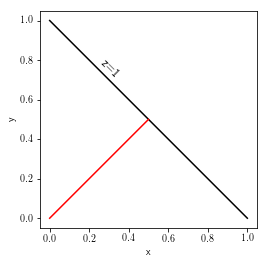

In [23]:
plt.plot([1, 0], [0, 1], 'k')
plt.plot([0, 0.5], [0, 0.5], 'r')
plt.xlabel('x')
plt.ylabel('y')
plt.axis('square')
plt.text(0.25, 0.77, 'z=1', rotation=-45, fontsize=12)

To understand the statistics of $z$, let's consider its *cumulative distribution function*, $\Phi$, which is the probability that $z$ is *less than* some specified value. In terms of the $(x, y)$ axis picture above, we calculate $\Phi$ by integrating $P(x,y)$ for all of the area below a line of constant $z$.

The next step is to realize that $P(x,y)$ has circular symmetry, so we are free to rotate our coordinates by 45&deg; so that the line of constant $z$ is horizontal. The height of this horizontal line along the new $y'$ axis is $z / \sqrt{2}$. Because of the circular symmetry of the joint pdf, we know that $P(x',y') = P(x,y)$. Now we can write a simple expression for $\Phi$.

$$
\begin{align}
\Phi(z) &= \int_{-\infty}^{\infty} \int_{-\infty}^{z/\sqrt{2}} P(x',y') dx' dy' \\
&= \left( \int_{-\infty}^{\infty} P(x') dx' \right) \left( \int_{-\infty}^{z/\sqrt{2}} P(y') dy' \right)
\end{align}
$$

The first term in parentheses is an integral of $P(x)$ over all values of $x$, which we know is equal to one because of the normalization of probability distributions. The second term is just the cumulative distribution function for $y$, except that we are integrating up to a value of $z / \sqrt{2}$. This means that $z$ and $y$ have the same cumulative distribution function if we simply rescale $z \rightarrow z / \sqrt{2}$. Since $y$ is Gaussian, this implies that $z$ must be Gaussian as well.

By considering some slightly more complicated cases, we can come up with the following properties for the sum of Gaussian numbers:

If $x$ and $y$ are numbers drawn from independent Gaussian distributions with $(\mu_x, \sigma_x)$ and $(\mu_y, \sigma_y)$, then $z = x + y$ is also Gaussian with $\mu_z = \mu_x + \mu_y$ and $\sigma_z^2 = \sigma_x^2 + \sigma_y^2$. It is important to remember to add the *variances* of the distributions ($\sigma^2$), not the standard deviations ($\sigma$).

## Fourier transform

Now we are ready to really understand how to get from a map to a power spectrum.

The Fourier transform is a linear, invertible operation that converts a function that is defined over space (like a map) to one that is defined over wave number (or wavelength). For a smooth function, we can write the Fourier transform as 

$$
\hat{f}(k) = \int_{-\infty}^{\infty} f(x) \exp \left( 2 \pi i x k \right) dx
$$

However, we are usually working with pixelized maps, so $f(x)$ is only defined at discrete values of $x$: $x_0$ through $x_{N-1}$. Then we can convert this integral to a summation (discrete Fourier transform):

$$
\hat{f}(k) = \sum_{i=0}^{N-1} f(x_i) \exp \left( 2 \pi i k x_i / N \right)
$$

For this case, the allowed values of $k$ are integers in the range $[0, N-1]$.

The Fourier transform represents the same function as $f(x)$ but expresses it in terms of the sum over waves with wavelength $k$ and amplitudes given by $\hat{f}(k)$. 

Here are some examples:

(0, 32)

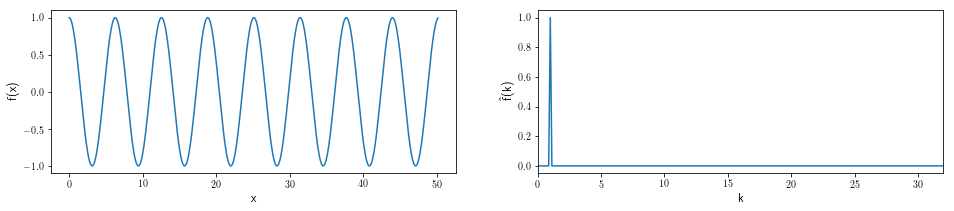

In [26]:
plt.figure(figsize=(16, 3))
x = np.arange(0, 16 * np.pi, np.pi / 32)
fx = np.cos(x)
plt.subplot(1, 2, 1)
plt.plot(x, fx)
plt.xlabel('x', fontsize=12)
plt.ylabel('f(x)', fontsize=12)
k = np.arange(0, 64, 0.125)
fk = np.real(np.fft.fft(fx1)) / 256.
plt.subplot(1, 2, 2)
plt.plot(k, fk)
plt.xlabel('k', fontsize=12)
plt.ylabel('\^{f}(k)', fontsize=12)
plt.xlim(0, 32)

**Example 1**: 
* $f(x)$ is a simple *cos* function with wavelength $\lambda = 2 \pi$ and amplitude equal to one. 
* $\hat{f}(k)$ is zero except it is equal to one at wavenumber $k = 2 \pi / \lambda = 1$.

(0, 32)

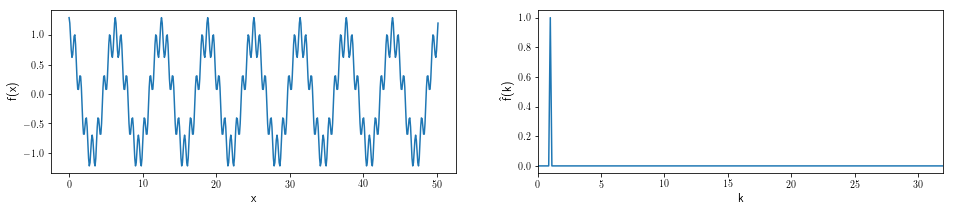

In [27]:
plt.figure(figsize=(16, 3))
x = np.arange(0, 16 * np.pi, np.pi / 32)
fx = np.cos(x) + 0.3 * np.cos(8 * x)
plt.subplot(1, 2, 1)
plt.plot(x, fx)
plt.xlabel('x', fontsize=12)
plt.ylabel('f(x)', fontsize=12)
k = np.arange(0, 64, 0.125)
fk = np.real(np.fft.fft(fx1)) / 256.
plt.subplot(1, 2, 2)
plt.plot(k, fk)
plt.xlabel('k', fontsize=12)
plt.ylabel('\^{f}(k)', fontsize=12)
plt.xlim(0, 32)

**Example 2**:
* $f(x)$ is the sum of a *cos* function with amplitude 1 and wavelength $2 \pi$ plus another *cos* function with amplitude 0.3 and wavelength $\pi / 4$.
* $\hat{f}(k)$ is equal to 1 at $k = 1$, equal to 0.3 at $k = 8$, and equal to zero elsewhere.

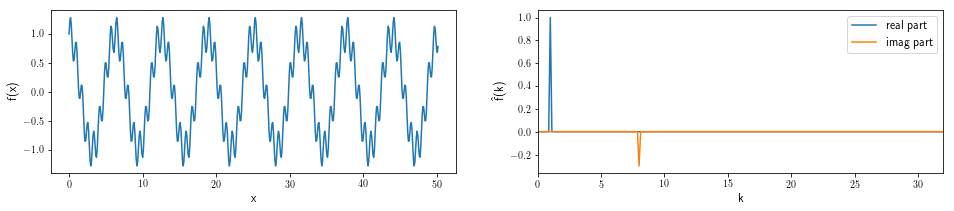

In [30]:
plt.figure(figsize=(16, 3))
x = np.arange(0, 16 * np.pi, np.pi / 32)
fx = np.cos(x) + 0.3 * np.sin(8 * x)
plt.subplot(1, 2, 1)
plt.plot(x, fx)
plt.xlabel('x', fontsize=12)
plt.ylabel('f(x)', fontsize=12)
k = np.arange(0, 64, 0.125)
fk = np.fft.fft(fx) / 256.
plt.subplot(1, 2, 2)
plt.plot(k, np.real(fk), label='real part')
plt.plot(k, np.imag(fk), label='imag part')
plt.xlabel('k', fontsize=12)
plt.ylabel('\^{f}(k)', fontsize=12)
plt.xlim(0, 32)
plt.legend(fontsize=12)

**Example 3**:
* $f(x)$ is the sum of a *cos* function with amplitude 1 and wavelength $2\pi$ plus a *sin* function with amplitude 0.3 and wavelength $\pi/4$.
* $\hat{f}(k)$ is equal to 1 at $k = 1$, equal to $-0.3 i$ at $k = 8$, and equal to zero elsewhere.

Here we see that the Fourier transform is complex-valued (even though $f(x)$ is purely real) and the real vs complex part has to do with the *phase* of the wave. Switching from *cos* to *sin* changes phase by 90&deg; and converts the Fourier amplitude from real to complex.

We should also look at the allowed range of $k$ values:
* $x$ ranges from 0 to $16 \pi$. This means that the longest allowed wavelength is $\lambda = 16 \pi$ or $k = 2 \pi / \lambda = 1 / 8$, so the smallest step size in $k$ is $1/8$.
* The step size for $x$ is $\pi / 32$. Naively, we might expect this to mean that the maximum $k$ value is $(2 \pi) / (\pi / 32) = 64$. But I only plotted out to $k = 32$ in the figure above. Let's see what happens if we plot the full range of $\hat{f}(k)$ out to $k = 64$.

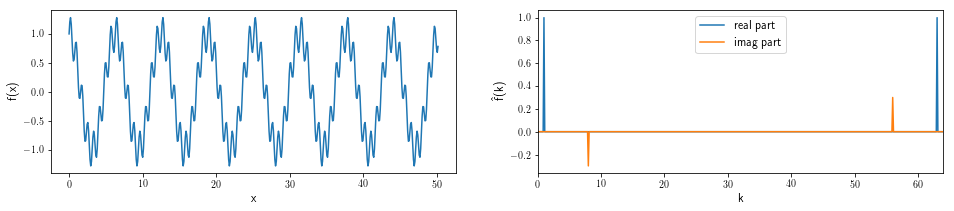

In [29]:
plt.figure(figsize=(16, 3))
x = np.arange(0, 16 * np.pi, np.pi / 32)
fx = np.cos(x) + 0.3 * np.sin(8 * x)
plt.subplot(1, 2, 1)
plt.plot(x, fx)
plt.xlabel('x', fontsize=12)
plt.ylabel('f(x)', fontsize=12)
k = np.arange(0, 64, 0.125)
fk = np.fft.fft(fx1) / 256.
plt.subplot(1, 2, 2)
plt.plot(k, np.real(fk), label='real part')
plt.plot(k, np.imag(fk), label='imag part')
plt.xlabel('k', fontsize=12)
plt.ylabel('\^{f}(k)', fontsize=12)
plt.xlim(0, 64)
plt.legend(fontsize=12)

It turns out that $\hat{f}(k)$ in the range $k \in [32,64]$ looks just like a reflection of $\hat{f}(k)$ on the range $k \in [0,32]$, except that the imaginary part has flipped sign. This is a consequence of Nyquist theorem, which tells us that if we have a grid with step size $\Delta x$, then the shortest wavelength we can represent is $2 \Delta x$.

Another way to think about this is in terms of the total information:
* In the example above, $f(x)$ contains 512 values (full range is $16 \pi$, step size is $\pi / 32$)
* $\hat{f}(k)$ has the same total amount of information, but half of the information (256 values) is in the real part and half (the other 256) is in the imaginary part. We saw that the step size for $k$ is $1 / 8$, so 256 values yields a range from 0 to 32.

(As an aside, if $f(x)$ is *complex-valued*, then $\hat{f}(k)$ will have additional information in the $k \in [32,64]$ range... but our maps are always real-valued.)

### Two-dimensional Fourier transform

A map of the CMB is two-dimensional, unlike the $f(x)$ that we were considering above. Fortunately it is straightforward to extend the Fourier transform to two dimensions.

Now we have our map, $\Theta(x, y)$, which is a function of two coordinates. The Fourier map is also two-dimensional, $\hat{\Theta}(k_x, k_y)$, where $k_x$ is the wavenumber for waves that oscillate in the $x$ direction and $k_y$ is the wavenumber for waves that oscillate in the $y$ direction. A wave that is oscillating at a +45&deg; angle, can be represented by a point with equal $k_x$ and $k_y$ values.

Let's try a couple simple examples:

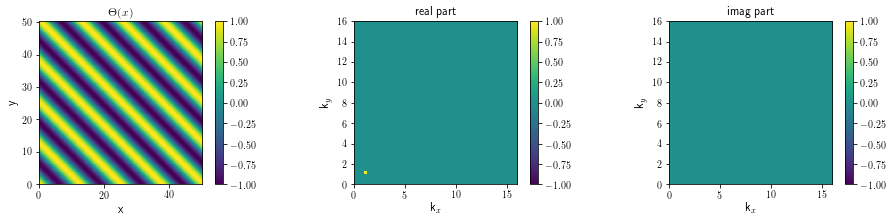

In [62]:
plt.figure(figsize=(16,3))
x = np.tile(np.arange(0, 8 * np.pi, np.pi / 64), (512, 1))
y = x.transpose()
fx = np.cos(x + y)
plt.subplot(1, 3, 1)
plt.imshow(fx, extent=(0, 16*np.pi, 0, 16*np.pi), origin='lower', vmin=-1, vmax=1)
plt.colorbar()
plt.xlabel('x', fontsize=12)
plt.ylabel('y', fontsize=12)
plt.title('$\Theta(x)$', fontsize=12)
fk = np.fft.fft2(fx) / (512**2 / 2.)
plt.subplot(1, 3, 2)
plt.imshow(np.real(fk[0:64,0:64]), origin='lower', vmin=-1, vmax=1, extent=(0, 16, 0, 16))
plt.colorbar()
plt.xlabel('k_x', fontsize=12)
plt.ylabel('k_y', fontsize=12)
plt.title('real part', fontsize=12)
plt.subplot(1, 3, 3)
plt.imshow(np.imag(fk[0:64,0:64]), origin='lower', vmin=-1, vmax=1, extent=(0, 16, 0, 16))
plt.colorbar()
plt.xlabel('k_x', fontsize=12)
plt.ylabel('k_y', fontsize=12)
plt.title('imag part', fontsize=12)

**Example 1**:
* $\Theta(x,y)$ is a *cos* function that oscillates in the +45&deg; direction with amplitude equal to 1.
* $\hat{\Theta}(k_x, k_y)$ is equal to 1 at $k_x = k_y = 1$ and zero elsewhere. The imaginary part is zero.

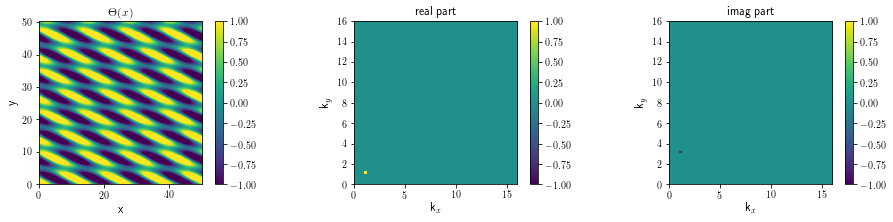

In [79]:
plt.figure(figsize=(16,3))
x = np.tile(np.arange(0, 8 * np.pi, np.pi / 64), (512, 1))
y = x.transpose()
fx = np.cos(x + y) + 0.75 * np.sin(x + 3. * y)
plt.subplot(1, 3, 1)
plt.imshow(fx, extent=(0, 16*np.pi, 0, 16*np.pi), origin='lower', vmin=-1, vmax=1)
plt.colorbar()
plt.xlabel('x', fontsize=12)
plt.ylabel('y', fontsize=12)
plt.title('$\Theta(x)$', fontsize=12)
fk = np.fft.fft2(fx) / (512**2 / 2.)
plt.subplot(1, 3, 2)
plt.imshow(np.real(fk[0:64,0:64]), origin='lower', vmin=-1, vmax=1, extent=(0, 16, 0, 16))
plt.colorbar()
plt.xlabel('k_x', fontsize=12)
plt.ylabel('k_y', fontsize=12)
plt.title('real part', fontsize=12)
plt.subplot(1, 3, 3)
plt.imshow(np.imag(fk[0:64,0:64]), origin='lower', vmin=-1, vmax=1, extent=(0, 16, 0, 16))
plt.colorbar()
plt.xlabel('k_x', fontsize=12)
plt.ylabel('k_y', fontsize=12)
plt.title('imag part', fontsize=12)

**Example 2**:
* $\Theta(x,y)$ is the sum of a *cos* function with amplitude 1 and wavelength $2\pi / \sqrt{2}$ in the +45&deg; direction and a *sin* function with amplitude 0.75 and wavelength $2 \pi / \sqrt{13}$ in the +72&deg; direction.
* $\hat{\Theta}(x,y)$ is equal to +1 at $\vec{k} = (1, 1)$, is equal to $-0.75 i$ at $\vec{k} = (1, 3)$, and is equal to zero elsewhere.

### Fourier transform of a Gaussian random field

